In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import pickle
#import sys
#sys.path.append('../')
#from code_line.util import *

In [2]:
# Read unified kg
def read_kg(path):
    f = open(path,'r')
    lines = f.readlines()
    L = []
    for line in lines:
        l = line.strip('\n').split(' ')
        L += [l]
    L = np.array(L)
    return L[:,0:2]

# Get meta
def gt_dict(p):
    G = []
    # similarity
    # meta in kg
    p1 = set(tit2meta['e'+p[0]])
    p2 = set(tit2meta['e'+p[1]])

    # meta intersection
    meta_common = len(p1.intersection(p2))
    # jacard
    meta_union = len(p1.union(p2))
    return [float(p[2]), int(meta_common), round(meta_common/meta_union , 4)]

# Read LINE output pair
def read_pair(path):
    f = open(path,'r')
    lines = f.readlines()
    L = []
    for line in lines:
        l = line.strip('\n').split('\t')
        L += [l]
    L = np.array(L)
    return L

# Plot LINE cosine similarity vs Meta

In [ ]:
# Eead unified kg
unified_kg = read_kg('../dataset/line_kg/line-kg.txt')

# title : meta dictionary
tit2meta = defaultdict(list)
for i in unified_kg:
    if i[1] not in tit2meta[i[0]]:
        tit2meta[i[0]].append(i[1])

In [ ]:
line_output = read_pair('code_line/result/pairs/line-pairs-top50.txt')

In [ ]:
chunks = 60
pool = Pool(processes=chunks)
Ans = pool.map(gt_dict, line_output[:,0:3])
Ans = np.array(Ans)

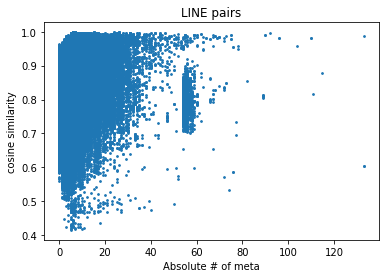

In [8]:
plt.scatter(Ans[:,1], Ans[:,0], s=3)

plt.xlabel("Absolute # of meta")
plt.ylabel("cosine similarity")
plt.title("LINE pairs")
plt.show()

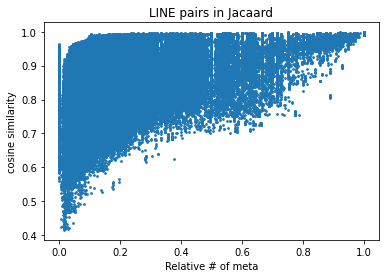

In [9]:
plt.scatter(Ans[:,2], Ans[:,0], s=3)

plt.xlabel("Relative # of meta")
plt.ylabel("cosine similarity")
plt.title("LINE pairs in Jacaard")
plt.show()

# Plot LINE union SBert --> weighted sum rerank

In [23]:
# PR
def precision_recall_thres(pair_fil, kk_ans, threshold):
    L = round(len(pair_fil) * threshold)
    pair_fil = pair_fil[0:L+1]
    rule_ans_pair = set([tuple(i) for i in pair_fil]).intersection(kk_ans) 
    num_pair = len(rule_ans_pair)
    re, pre = num_pair/len(kk_ans), num_pair/len(pair_fil)
    #f1 = round(2*(pre*re)/(pre+re) , 4)
    re, pre = round(re,4), round(pre,4)
    #print(f'recall@{threshold}: {num_pair}/{len(kk_ans)} = {re},    precision@{threshold}: {num_pair}/{len(pair_fil)} = {pre},    f1@{threshold}: {f1}')
    return [re,pre]

rate = [round(0.05 + 0.05*i,2) for i in range(20) ] # calculate precision and recall @ 0.95, 0.9, 0.85, ....

In [30]:
# read ground truth

# read title index map
i2e, e2i = {}, {}
f = open('../../dataset/line_kg/line-kg.idx.txt', 'r')  
lines = f.readlines()
for line in lines:
    l = line.strip('\n').split('\t')
    if l[1][0]=='e':
        e2i[l[0]] = int(l[1][1:])
        i2e[int(l[1][1:])] = l[0]

# read ground truth
with open ('../../dataset/labelled_gt/kk_same.pkl', 'rb') as fp:
    gt_same = pickle.load(fp)
with open ('../../dataset/labelled_gt/kk_similar.pkl', 'rb') as fp:
    gt_similar = pickle.load(fp)
with open ('../../dataset/labelled_gt/kk_notsame.pkl', 'rb') as fp:
    gt_notsame = pickle.load(fp)

# ground truth to index
def gt2idx(gt):
    gt_idx = []
    gt = list(gt)
    for idx in range(len(gt)):
        e1, e2 = e2i[gt[idx][0]], e2i[gt[idx][1]]
        #if e1 >= e2:
        #    gt_idx.append(tuple([str(e2), str(e1)]))
        #else:
        gt_idx.append(tuple([str(e1), str(e2)]))
    return gt_idx

gt_same_idx = gt2idx(gt_same)
gt_similar_idx = gt2idx(gt_similar)
gt_notsame_idx = gt2idx(gt_notsame)

gt_all = gt_same_idx + gt_similar_idx + gt_notsame_idx

In [31]:
def filter_gt(p):
    if tuple([p[0], p[1]]) in gt_all:
        return list(p)
    else:
        return None

In [37]:
line_output = read_pair('code_line/result/pairs/line-pairs-top50.txt')
sbert_output = read_pair('code_line/result/pairs/sbert-pairs-top50.txt')

sbert_output[:,[2,3]] = sbert_output[:,[3,2]]

all_output = np.concatenate((line_output, sbert_output),0)
len(all_output)

2726700

In [38]:
ALL = []
for p in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]: #
    new_array = []
    for i in all_output:
        new_array.append([i[0],i[1],round( p*float(i[2]) + (1-p)*float(i[3]), 5 )])
    new_array = [tuple(row) for row in new_array]
    new_array = np.array(list(set(new_array)))
    
    chunks = 60
    pool = Pool(processes=chunks)
    all_filter = pool.map(filter_gt, new_array)
    all_filter = np.array([i for i in all_filter if i!=None])
    all_pairs = all_filter[all_filter[:, 2].argsort()][::-1]
    
    ALL.append(all_pairs)

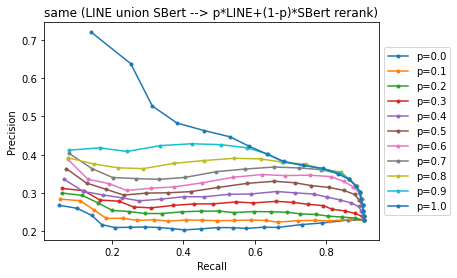

In [39]:
target =  gt_same_idx

record_all = []
for L in ALL:
    record = []
    for i in rate:
        record.append(precision_recall_thres([tuple([i[0],i[1]]) for i in L], target, i))
    record_all.append(record)

fig, ax = plt.subplots()

p=0.0
for i in record_all:
    plt.plot(np.array(i)[:,0], np.array(i)[:,1], marker="o",label=f"p={round(p,1)}", markersize=3)
    p+=0.1

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("same (LINE union SBert --> p*LINE+(1-p)*SBert rerank)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()